# Todo list
Things to work on

1. **Correct gradient term and early exaggeration relationship:**
    - Experiment with several datasets (mnist, c_elegans custom?) with the correct gradient
      and with/without early exaggeration to see whether there is any difference or effect?
    - Subsample data so we can keep track of how things go about
    - Start with custom simple dataset, controllable experiment
    - **Experimental setup:** 
      1. Custom Hierarchical data: 
      
         Run experiment with correct gradient for bigger and bigger datasets
         Turn early exaggeration off, and see if clusters still form.
         Turn early exaggeration on, and see if theres a difference.
         Use wrong gradient and see if clusters (no early exaggeration) form.
      2. Repeat with bigger datasets:
         Same as above
    
2. **Experiment with increased attractive forces:**
    - Take a dataset (mnist possible) and perform some experiments with differing amounts of attraction
    - See whether that leads to embeddings where points aren't pushed to the boundary

3. **Gaussian distribution for lower dimensional embedding:**
    - Derive the gradient using a gaussian instead of a t-distribution
    - For motivation of gaussian see teams chat
    - Implement gaussian gradient, use on same datasets as above, compare results

4. **Custom hierarchical dataset construction**
    - Create a custom hierarchical dataset for use in all our future experiments.
    - Clear hierarchies
    - Trace out a "branch" of the tree, rotate/copy/paste it to form a '+' 

# Hyperbolic space gradient analysis

In the T-SNE paper, the t-distribution is introduced to fight against the crowding problem. So if in high dimensions we have n equidistant points, then in 2 (embedding) dimensions, we can't faithfully capture this equidistance and instead points will get squished together.

\
\
**Mathematically:**

$p_{ij} > 0$ get represented by $q_{ij} = 0$ because we can't faithfully model $y_i$ and $y_j$ to be close due to a lower dimensional embedding.

So then when we update along the direction $(y_i - y_j)$ with (spring) factor $(p_{ij} - q_{ij})$, because $q_{ij} = 0$, we only have a attractive force due to $(p_{ij} - q_{ij}) = (p_{ij} - 0) > 0$.

To make the points not crush eachother into a small area (crowding), we use a t-distribution for the lower dimensional embeddings to ensure that we can still faithfully capture the same high dimensional probabilities (using less low dimensional space), by spreading the points in low dimensions out more since we are using a heavy-tailed distribution to match affinities.

\
\
\
**Hyperbolic case:**

In the hyperbolic scenario we might not need to use the t-distribution since space is expanded exponentially from the origin. This means that we do not have the crowding problem since a point in low dimensional space has enough space to accommodate for many equidistant points in high dimensional space due to the exponentially expanding nature of hyperbolic space.

Potential experiment: Use regular gaussian instead of t-distribution

# Correct gradient contribution to behaviour

**What is the contribution factor of the extra $d^{H}_{ij}$ in the gradient?**

Enlargers the gradient of the cost function. If 2 points are far apart this factor is big. So it further accentuates repulsion or attraction depending on $(p_{ij} - q_{ij})$. Causes points to attract or repel more.

Hypothesis: 
1. $d^{H}_{ij}$ probably speeds up convergence by increasing the attractive/repulsive forces initially when it matters, (when $(p_{ij} - q_{ij})$ is not approximately 0 yet)
2. Might introduce more numerical instability, practically we might be ofshooting the edge of the unit circle. (Requires more investigation)


\
\
**Why is it here in the hyperbolic scenario but not in the euclidean case?**

Probably as an artifact from using hyperbolic space, so we need an extra factor? Investigate analytically


# Interpreting Hyperbolic embeddings

**Why do we even want hyperbolic embeddings?**
- We think hyperbolic geometry is the underlying geometrical structure for hierarchical data
- Naturally models tree-like (hierarchical) data due to the nature of its exponentially expanding space


**How should we interpret visualizations on the Poincare Disk?**
- We expect clusters inside the disk, with clusters expanding outwards from the center. 
- The expansion outwards indicates hierarchical links between clusters closer to the center, and the clusters further out
- Clusters near the edge of the disk are very far apart from clusters in the center -> Hierarchical ordering
- Clusters near the border are actually far apart from other eachother even if they seem close on the disk


# Notes on Poincare Embeddings for Gene Expressions

Biology, and especially in the field of genetics, gene expression, it is common to want to understand the relationships between things. This is done through visualization, data analysis, etc..
Here a brief overview of how it works, how people generally proceed, and the why's.

**What is gene expression?**
- Gene expression refers to a part of the process of how genetic material turns into observable traits
  The most fundamental level at which the genotype (genetic material) gives rise to the phenotype (observable traits)

**What is this process of gene expression?**
- DNA:                contains your genetic material
- Gene activation:    a step where specific genes in your DNA are activated 
- Transcription:      here the activated gene(s) get copied and stored into a molecule called mRNA
- Translation:        the step where the mRNA molecule is used to build a protein
- Protein:            a protein is a complex molecule that has specific uses/tasks to fulfill. This directly affects the phenotype

**Why visualize gene expression in hyperbolic space?**
- Naturally contains hierarchical structure. We can basically assume this?

# Thesis notes

### [1] Some notes regarding what I've run and observations

**Planaria Data - 90% of data - Correct gradient - Approximate:**\
No instances of numerical instabilities have occurred yet as far as I know

**Planaria Data - 40% of data - Correct gradient - Exact:**\
No numerical instability issues afaik


### [2] Structure of the code
Running the algorithm involves the following stages:
1. Initialize **HyperbolicTSNE** object and run the **.fit_transform()** method

2. **.fit_transform()** calls the (private) **._fit()** method 

3. **HyperbolicTSNE** takes in an Optimizer object. In the default case this will be the SequentialOptimizer class

4. **SequentialOptimizer** requires a “config” to run properly. These are set at the beginning (before .1), through a dedicated function for initializing the config. 

- In the default case **.sequence_poincare()** The SequentialOptimizer works by chunking the optimization process into sequences. We can specify each chunk of the sequence through objects (a dictionary) which contains all the info for each block to run properly. These objects/blocks follow a standard format that must be adhered to We get two blocks in the SequentialOptimizer: EarlyExaggeration block and a GradientDescent block through the functions **add_block_early_exaggeration()** and **add_block_gradient_descent_with_rescale_and_gradient_mask()**

- Each block must internally contain information (see the add_block functions) specifying the optimization strategy to use (e..g gradient descent), and parameters. The optimization method is specified under the “function” dictionary key,  with the “params” key containing the params for the optimization method.

5. SequentialOptimizer has a **.run()** method which executes the function (optimization method). By default **.run()** calls the **.gradient_descent()** function in **solver.py**

6. The optimization method is specified in the **solver.py** file. 
Most code here deals with administrative/logging tasks, and other higher level functionality regarding optimization. The default implementation is roughly split into the following parts:
- Checks and initializing logging- Gradient computation (using cython implementation of lower level details)
- Logging of optimization step- Convergence checks The actual computation of the optimization step is split in several parts:
    Higher level detail in optimization method, cost function details in **cost_functions.py**, lower level details in tsne.pyx

7. **cost_functions.py** contains the wrapper code that calls the lower level implementation for computing the gradient. We can find the code here for executing exact, or bh-tsne gradient descent. 

8. **tsne.pyx** contains the low level details of the gradient computation. Here we also find the code for the quad-tree datastructure, exponential map, and other calculation functionality.


### [2.1] Adding new cost functions (with different parameters)
How to add a new cost function and make it compatible with the pre-existing structure.

How to use the config/params dicts to get it to do what we want: 
- Constructing the **HyperbolicTSNE()** object requires **opt_method** and **opt_params** arguments.
- We can specify a custom **opt_method** and its associated **opt_params** 
- By default this is **SequentialOptimizer** which has **HyperbolicKL** hardcoded into it.
  So we should modify this or come up with a new optimizer class
- I need to explicitly update the params for the cost function to include the new embedding y_i
- Another thing; The data is worked on flatenned. (**.ravel()**) is used during optimization. So make sure to account for that

Currently the way to feed extra parameters into the CostFunction classes (to its constructor when it gets constructed) is to append a dictionary containg (k,v) pars of parameter and its value to the opt_params field in Experiment. This is a very ugly way of doing it but the current best solution ---> Refactor at some point?


### [3] Turning on/off acceleration structure
In the **opt_config**, we can set a boolean for the **exact** flag. We can specify exact or an approximate computation of the gradient.

# Results analysis

**Mnist dataset**
Results for incorrect and correct gradient look the same

# Data generation

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(130, 2)
(130,)


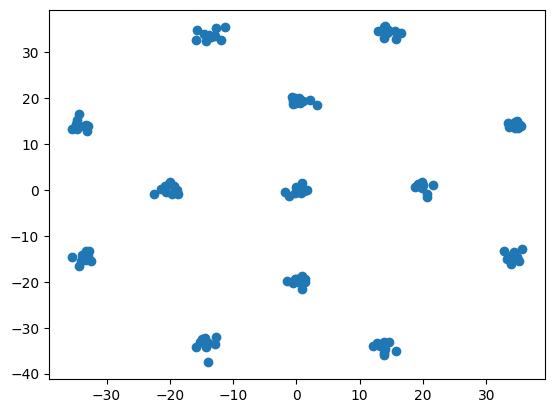

In [7]:
from data_gen import generate_tree_data
import numpy as np
from matplotlib import pyplot as plt

d = 20
angle = np.pi / 4
dim = 2
data, labels = generate_tree_data(d, angle, dim)
print(data.shape)
print(labels.shape)

plt.scatter(data[:, 0], data[:, 1])
plt.show()